# Quantum Substring Comparison
#

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Gate
from math import log2, floor
import numpy as np  
from qiskit_aer import AerSimulator  
from qiskit.visualization import plot_histogram, plot_bloch_vector
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg  
import matplotlib.pyplot as plt  
import matplotlib

## Introduction

In recent years has gained ground the emerging field of quantum computing,giving the possibility to implement algorithms with superior asymptotic performance to those achievable using classical computers.   
The aim of the project is to provide an implementation of a quantum algorithm, which solve a classical problem related to text processing, and compare the performance with a classical implemention of the same algorithm.
Given two input strings, x and y, both of length n, and a value d ⩽ n, we want to verify the following conditions:  
the existence of a common prefix of length d, the presence of a common substring of length d beginning at position j  and, the presence  of any common substring of length d beginning in both strings at the same position.
Formally, given tow input strings x and y,both of length n, whose character are drown from an alphabet S, and a parameter d,with 0 < d ⩽ n, we want to solve the following problems:
- the Fixed Prefix Matching (FPM) problem, which tests for the existence of  a common prefix of length d between x and y, checks whether:  
   <pre>                                  x[0,1...d-1]= y[0,1...d-1]</pre>                                        
- the Fixed Factor Matching (FFM) problem, which test, for a given parameter j, with 0 ⩽ j < n−d , the existence of a common substring(of length d) between x and y, starting at index j .
   <pre>                                  x[j,j+1...j+d-1]= y[j,j+1...j+d-1]            </pre>
- the Shared Fixed Substring Checking (SFSC) problem, which tests for  the existence of a common substring between x and y, of length d,     starting at index j in both strings. It tests whether:
   <pre>                        ∃ j : 0 ⩽ j < n−d and x[j,j+1...j + d − 1] = y[j,j+1...j + d − 1]     <pre>                                             

## A gentle introduction to quantum Computing

Qbit is the basic unit of quantum computation and can be understood as the quantum equivalent of the traditional bit used in
classical computers.
It is a two-state quantum mechanical system, one of the simplest quantum systems displaying the peculiarity of quantum mechanics, 
examples include the spin of the electron or the polarization of a single photon.  
In quantum mechanics a general quantum state can be represented by a vector defined on Hilbert space  $\mathcal{H}$, in particular a qbit, that is a very simple quantum mechanical system, can be represented as linear combination of two basis states |0$\rangle$ and |1$\rangle$:
$$ |\psi\rangle = \alpha|0\rangle + \beta|1\rangle\ \alpha,\beta \in \mathbb{C}\ $$
where |$\alpha$|$^2$ and |$\beta$|$^2$ represent the probability of outcome  |0$\rangle$ and  |1$\rangle$ respectively. Because the absolute squares of the amplitudes equate to probabilities, it follows that $\alpha$ and $\beta$ must be constrained, according to the second axiom of probability theory, by the equation:
$$ |\alpha|^2 + |\beta|^2=1$$
This expression represent quantum superposition, a key concept that distinguishes quantum mechanical system from their classical counterpart.  
  
Multiple qbits taken together are referred to as a quantum registers.A quantum register |$\psi\rangle$=|q1,..qn$\rangle$ is the tensor product of constituent qbits:
$$ |\psi\rangle= \otimes_{i=1}^n q_i $$ 

### Quantum Operators

A qbit can be represented in the Bloch sphere.However, a qbit has four parameter but a sphere allows 
only three dimensional representation, so Bloch manipulated the definition to obtain this equation:
$$ \ket{\psi} = \cos \frac{\theta}{2} \ket{0} + e^{i \phi} \sin \frac{\theta}{2} \ket{1} $$

A quantum operation maps a point u on the unit sphere to some other point q on the unit sphere, 
so an operation can be represented by a matrix.
Moreover, we restrict these matrices to be linear and invertible, such matricies are called unitary.
- linearity
$$ A(\alpha \ket{\psi_1} + \beta \ket{\psi_2}) = \alpha A(\ket{\psi_1}) + \beta A(\ket{\psi_2})\
\forall \alpha, \beta \in \mathbb{C},\ \forall \ket{\psi_1}, \ket{\psi_2} \in \mathcal{H} $$
- invertibility
$$ U^\dagger U = I\ \ \
 UU^\dagger = I $$
                  where $U^\dagger$ is the complex conjugate of $U$ and $I$ is the identity matrix.   
The following are the elementary quantum operators we will use :
- NOT gate, formally it maps |0$\rangle$ to |1$\rangle$ and vice versa
$$
NOT = \begin{bmatrix} 0 & 1\\ 1 & 0\end{bmatrix}
$$ 

- CNOT gate, formally it maps |q$_0$,q$_1$ $\rangle$ to |q$_0$,q$_0$ $\oplus$q$_1$ $\rangle$
$$
CNOT = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{bmatrix}
$$

- SWAP gate, formally it maps |q$_0$,q$_1$ $\rangle$ to |q$_1$,q$_0$ $\rangle$, it could be obtained applying three times CNOT
$$
SWAP = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

- the FREDKIN gate, that consist in swap gate controlled by a single qbit
$$
FREDKIN = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0  \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0  \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix}
$$
- Toffoli gate, it  formally maps |q$_0$,q$_1$, q$_2$ $\rangle$ to |q$_0$,q$_1$, q$_0$ $\oplus$q$_1$ $\oplus$q$_2$ $\rangle$
$$
CX3 = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0  \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1  \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\end{bmatrix}
$$

we will assume that these gates have depth $\mathcal{O}{(1)}$.  

Now we will introduce two more gates, which have a non constant depth:
- Multiple CNOT, formally it maps |q$_0$,q$_1$,q$_2$...q$_{n-1}$ $\rangle$ to |q$_0$,q$_1$,q$_2$... ,q$_0$ $\oplus$ q$_1$ $\oplus$ q$_2$ $\oplus$ q$_{n-1}$ $\rangle$
- fanout, formally it maps  |q$_0$,q$_1$,q$_2$...q$_{n-1}$ $\rangle$ to |q$_0$,q$_0$ $\oplus$ q$_1$,q$_0$ $\oplus$ q$_2$...q$_0$ $\oplus$ q$_{n-1}$ $\rangle$
  
They can both be implemented with depth $\mathcal{O}{(log(n))}$

### Quantum Boolean Oracles

Given a function f: {0}$^n$ -> {1}$^n$,any quantum operator that maps a register containing the value of a given input x ∈ {0, 1}$^n$ into a register whose value depends on f (x) is called a quantum  boolean oracle.Formally,
$$
U_f|x,0\rangle=|x,f(x)\rangle
$$

### Quantum Complexity

 A quantum algorithm can be shaped using the quantum circuit computational model.It represent quantum algorithms as sequences
of quantum gates that manipulate qubits.This approach delves into the specifics
of how quantum operations are executed and provides a structured methodology
for designing and optimizing quantum algorithms.We assume the
circuit as being divided into a sequence of discrete time-steps, where the application of a single gate requires a single time-step. The depth of the circuit is the
total number of required time-steps and it is the time complexity measure

## Qiskit

The code will be implemented using qiskit, a python library used for quantum computing. 
Below you can find some utility routines, they will be used for running and printing the circuit.  

In [2]:
#print the quantum circuit passed to the function
# arg:
#    circuit: QuantumCircuit 
# return:
#    None
def draw_circuit(circuit: QuantumCircuit):
    circuit.draw(output='mpl',filename="image.jpg")
    fig, ax = plt.subplots()
    im = mpimg.imread('image.jpg')
    matplotlib.rcParams['figure.figsize'] = [5, 5]
    ax.axis('off')
    ax.imshow(im)

In [3]:
# run Quantum Circuit using Aer Simulator 
# arg:
#    circuit: QuantumCircuit 
#    shots: times you want to run the circuit
# return:
#    dictionary that contains results
def run(qc: QuantumCircuit, shots: int)->dict:
    simulator = AerSimulator(method='matrix_product_state')
    compiledCircuit = transpile(qc, simulator)
    job = simulator.run(compiledCircuit, shots = shots).result()
    result = job.get_counts(compiledCircuit)
    return result

In [4]:
#print results of the measurement
# arg:
#   results: dictionary that contains results
# return:
#    None
def counts(results: dict):
    for i in results :
        print(str(i)[::-1])

As regard operators, we will use qiskit implementation, except for fanout, for which we provide a $\mathcal{O}{(log(n))}$ implementation.
Finally, note that we will use qiskit mcx , even if it provides a $\mathcal{O}{(n)}$ implementation. 

Instruction(name='circuit-165', num_qubits=8, num_clbits=0, params=[])

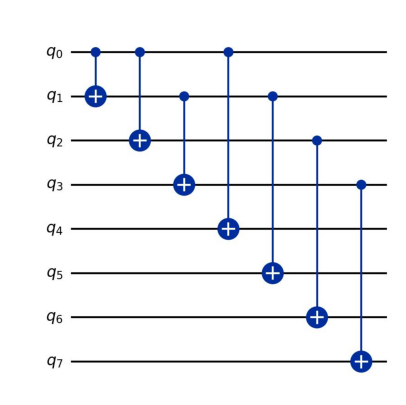

In [6]:
# run Quantum Circuit using Aer Simulator 
# arg:
#    n: number of copies to do
#    draw: boolean parameter for printing the gate  
# return:
#    a Gate
def FANOUT(n: int, draw: bool)->Gate:
    qc = QuantumCircuit(n)

    i = 1
    while(i < n):
        for j in range(i):
            if(j + i < n): qc.cx(j, j+i)
            else: break
        i= 2*i
        
    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="FANOUT")
    return qc

# Example of 
FANOUT(8, True)

## Algorithm 

In this section we will illustrate the different part of the algortihm. Theoretical detail are interspersed with python code implemenation

### Matcing Substring Vectors

Given i$\ge$0, we define the matching substring vectors $\lambda^{i}$,  for 0$\le$i$\le$log(d), as a bit vector of size n - 2$^i$ + 1, such that for  0$\le$j$\le$n-2$^i$, we have :  
$$
\lambda{^i}[j] =\begin{cases}
  1 \ \ if \ \ x[j..j+ 2^{i}-1] = y[j..j+2^{i}-1]\\
  0 \ \         otherwise 
\end{cases}$$
Such vectors can be recursively computed by means of the following relation:
$$
\lambda{^i}[j] =\begin{cases}
  1 \ \  \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \  \ \ \ \ \ \ \ \  \ \ \ if \ \ i=0 \ \ AND \ \ x[j]=y[j]\\
  0 \ \ \ \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ if \ \ i=0 \ \ AND  \ \ x[j]\ne y[j] \\
  \lambda^{i-1}[j] \ \ AND  \ \ \lambda^{i-1}[j + 2^{i-1}] \ if \ i>0
\end{cases}$$

Therefore, we can compute  recursively $\lambda{^i}$ from $\lambda^{i-1}$, while $\lambda{^0}$, that is the base case, can be computed by comparing characters of vectors x and y.  
Below you can find a qiskit circuit that implement this recursion.

#### Gate M implementation

gate M performs, $\forall$ x, y $\in${0,1}$^n$ the following mapping:  
$$
M|x>|y>|0^{n}>=|x>|y>|\lambda^0>
$$
Based on the simple following relation:
$$
\lambda^0[j]=(x_j \ \ AND \ \ y_j) \ \ \oplus \ \ (-x_j \ \ AND \ \ -y_j)
$$ 

Instruction(name='circuit-168', num_qubits=12, num_clbits=0, params=[])

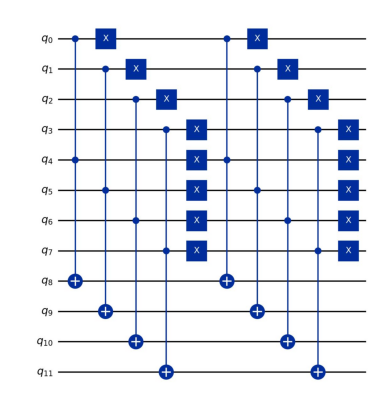

In [7]:
#Calculate λ^i from λ^i-1 for each 0<i<=log(d)
# arg 
#    n: dimension of the register  
#    draw: boolean parameter for printing the gate 
# return
#   a gate 

def M(n: int, draw: bool)->Gate:
    qc = QuantumCircuit(3*n)

    for i in range(n):
        qc.ccx(i, i + n, i + 2*n)
        qc.x(i)
        qc.x(i + n)
        qc.ccx(i, i+ n, i+ 2*n)
        qc.x(i)
        qc.x(i + n)
        
    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="M")
    return qc 

M(4, True)

Moreover, note that first set of CNOT gate and second one can be executed in parallel ,so the overall depth of the circuit is $\mathcal{O}{(1)}$ 

#### Gate EXT implementation

|$\lambda^{i}$> is computed from |$\lambda^{i-1}$> using EXT$_i$ operator, formally it operates the following mapping:  
$$
\forall i : 0\le i \le \lfloor log(d) \rfloor \ \ \ EXT_i|\lambda^{i-1}>|0^n>=|\lambda^{i-1}>|\lambda^{i}>
$$
Gate EXT$_i$ implement the recursive step

Instruction(name='circuit-171', num_qubits=12, num_clbits=0, params=[])

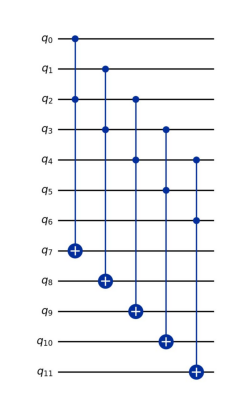

In [8]:
#Calculate λ^i from λ^i-1 for each 0<i<=log(d)
# arg 
#    n: dimension of the register 
#    i: index of λ vector we want to extend 
#    draw: boolean parameter for printing the gate 
# return
#   a gate 

def EXT(n: int, i: int, draw: bool)->Gate:

    qc = QuantumCircuit(2*n - 2**i)

    for j in range(n -2**i):
        qc.ccx(j, j + 2**i, j + n)
        
    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="EXT" + str(i))

    return qc 

# calculating λ^2 from λ^1 where starting register dimension is n = 8 
EXT(7, 1, True)

Note that CCNOT gates can be splitted in two groups(where i is the value passed to the functon EXT):
- CCNOT starting in position $2^i$k,$2^i$k+1...,$2^i$k + $2^{(i-1)}$ for k=0,2,4...
- CCNOT starting in position $2^i$k,$2^i$k+1...,$2^i$k + $2^{(i-1)}$ for k=1,3,5...  
Both CCNOT groups can be performed in parallel so the depth circuit that implement $EXT_i$ operator is $\mathcal{O}{(1)}$. Therefore, the overall circuit depth for calculating $\lambda$ vectors is $\mathcal{O}{(log(d))}$ 

### Power based decomposition of a string

Let $\bar{d}$= $\bar{d}$[0,1...$\lfloor$ log(d) $\rfloor$] being the vector storing the bit representation of d in its reversed order, so:
$$
d = \sum_{i=0}^{\lfloor log(d) \rfloor} \bar{d}[i] 2^i
$$
We use the expression $\bar{d}$[0:m] to denote the partial sum of such binary representation,formally we have:
$$
d[0:m] = \sum_{i=0}^{m} \bar{d}[i] 2^i
$$
We set by default $\bar{d}$[0:i]=0 $\forall$ i<0  
In addition let S be the positions of d where d[i]=1, in increasing order, so that d =$\sum_{i\in{S}}2^i$. Now consider the following decomposition of a string w:  
$$
w=\uplus_{i\in{S}}w[\bar{d}[0:i-1]..\bar{d}[0:i]-1]
$$
Such a decomposition is called power-pased-decomposition

#### Reversal Operator

Operator REV inverts position of its qbit, formally:
$$
REV|q>\ = |\bar q>
$$

Instruction(name='circuit-174', num_qubits=7, num_clbits=0, params=[])

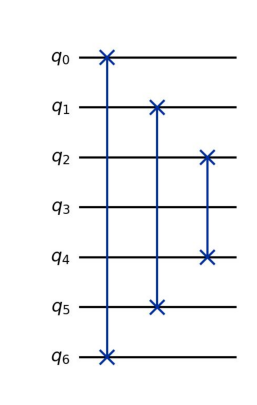

In [9]:
#Reverse qbits of a register
# arg 
#    n: dimension of the register
#    draw: boolean parameter for printing the gate 
# return
#   a gate 

def REV(n: int, draw: bool) -> Gate:
    qc = QuantumCircuit(n)

    for i in range(0, floor(n/2)):
        qc.swap(i, n - i - 1)

    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="REV")
    return qc 

#Example:
#Reverse a 7 qbits register 
REV(7, True)

Moreover, it is easy to see that all SWAP can be performed in parallel, so we can build a circuit for this operator with depth $\mathcal{O}{(1)}$ 

### Vectors of results

Before getting in to the details of how the vector of results D is build, we want to mark this interesting property, 
it basically says that two factors of x and y, starting at the same position j matching if and only if, the strings of their power based decomposition matching each other, formally :   
  
Let x and y be any two strings of length n over some alphabet $\sum$and let d be a constant, with 0 < d ⩽ n. For a given j such that 0 ⩽ j < n − d, we have:  
$$
x[j .. j + d − 1] = y[j .. j + d − 1] \longleftrightarrow \land_{i \in S}\lambda^{i}[j+\bar{d}[0:i-1]]=1
$$
Based on this property the algorithm mantain the set of vector $D^i$,for -1 ⩽ i ⩽ $\lfloor$log(d)$\rfloor$,where :  
$$
D^i[j+\bar{d}[0:i]]=1 \longleftrightarrow  x[j..j + \bar{d}[0,i] − 1] = y[j..j + \bar{d}[0,i] − 1]
$$
The idea is to check, at i-th step, if x and y have a common factor starting in position j, if so, shift $D^i$ of $2^i$ positions,formally:
$$
D^i = (D^{i−1} ∧ λ^{i} ) ≫ 2^i
$$

In the end:
$$
\forall j⩽ n -d \ \ \  D^{\lfloor log(d) \rfloor}[(j + d)mod(n)]=1 \longleftrightarrow x[j .. j + d − 1] = y[j .. j + d − 1]
$$
The correctness of this procedure is justified by the first property exhibited in this paragraph.  
Please note that since we assume that an empty substring starting at position j is always shared between the two strings, for any value 0 ⩽ j < n,the vector can be initialized to $D^1$ = $1^{n+1}$ .

#### Controlled Rotation Gate

Operator $ROT_k$ applied a rightward rotation of k position to a register r, so that element at position i we will found at position (i+s)mod(n), in addition the operator assumes that |r|=$2^p$ for some p $\ge$0 and k = $2^m$ for 0$\le$m$\le$log(n).Formally the operator $ROT_k$ apply this permutation:
$$
ROT_k|q_0,q_1,q_2,...q_{n-1}>=|q_{n-k},q_{n-k+1},q_{n-k+2},...q_{n-k-1}>
$$

However, we are interested in a controlled version of $ROT_k$, where the rotation is applied if and only if a control bit, said c, is set to 1. Formally the operator $CROT_k$ applied this mapping:
$$
CROT_k|c,q_0,q_1,q_2,...q_{n-1}> = \begin{cases}
|c,q_{n-k},q_{n-k+1},q_{n-k+2},...q_{n-k-1}>  \ \ \ \ \ \ \ if \ \ |c> = |1> \\
|c,q_0,q_1,q_2,...q_{n-1}>  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ if \ \ |c> = |0> 
\end{cases}
$$

Finally, note that due to modular rotation, the procedure could find common circular factor, but we can solve this issue assuming that the two strings must end with two distinct special character  # and %, such that #,% $\notin \sum$.Moreover, if the length of the string is not a power of two, we can concatenate to that its final special character any arbritary numbers of times.

Instruction(name='circuit-177', num_qubits=9, num_clbits=0, params=[])

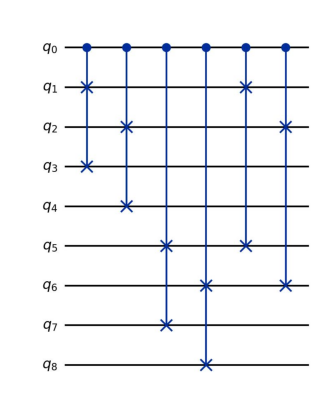

In [10]:
#controlled k rightward shift  of a register
# arg 
#    n: dimension of the register
#    k: steps of right circular shift
#    draw: boolean parameter for printing the gate 
# return
#   a gate 

def CROT(n: int, k: int, draw: bool)->Gate:

    qc = QuantumCircuit(n +1)

    for i in range(1, int(log2(n) - int(log2(k))+ 1)):
        for j in range(0, int(n/(k*2**i))):
            for x in range(k*j*2**i, k*j*2**i + k):
                qc.cswap(0, x + 1, 1 + x + k*2**(i-1))

    if(draw):draw_circuit(qc)
    qc = qc.to_gate(label="ROT" + str(k))
    return qc 

# a controlled 2- circular right shift of a register of size n=8  
CROT(8,2, True) 

It can be proven that build a circuit for a circular shift has a depth $\mathcal{O}{(log(n) - log(m))}$.In addition, the usage of a control qbit increase the depth of the circuit by a factor $\mathcal{O}{(n)}$ but the usage of n ancialle qbits that store a copy of the control qbit c reduce the growth to $\mathcal{O}{(log(n))}$.Therefore, the final depth of our operator will be $\mathcal{O}{(log^2(n))}$

Instruction(name='circuit-180', num_qubits=16, num_clbits=0, params=[])

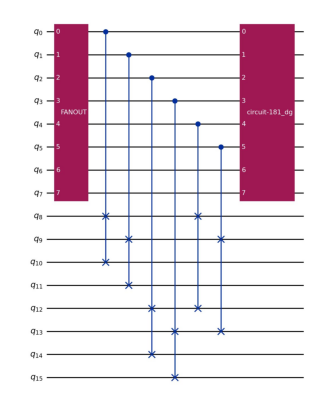

In [11]:
#controlled k rightward shift  of a register using ancilla qbits
# arg 
#    n: dimension of the register
#    k: steps of right circular shift
#    draw: boolean parameter for printing the gate 
# return
#   a gate 

def CROTA(n: int, k: int, draw: bool)->Gate:
    qc = QuantumCircuit(2*n)

    fanout = FANOUT(n, False)
    qc = qc.compose(fanout,[i for i in range(n)])
    control=0

    for i in range(1, int(log2(n) - int(log2(k))+ 1)):
        for j in range(0, int(n/(k*2**i))):
            for x in range(k*j*2**i, k*j*2**i + k):
                qc.cswap(control, n + x,n + x + k*2**(i-1))
                control+=1

    qc = qc.compose(fanout.inverse(),[i for i in range(n)])
    
    if(draw):draw_circuit(qc)
    qc = qc.to_gate(label="ROT" + str(k))
    return qc
    
# a controlled 2- circular right shift of a register of size n=8 
CROTA(8,2, True) 

#### The controlled bitwise conjunction operator

Now, we present BCJ, it performs bit-to-bit logical and between two
registers, |a> and |b>, of n qubits, depositing the result within a third register |qi>. Formally,
$$
\land |a>|b>|0^{n}>=|a>|b>\otimes_{i=0}^{n-1}|a \land b>
$$
However, we are interested in a controlled version BCJ, called CBCJ. Formally, 
$$
\land |c>|a>|b>|0^{n}>=|c>|a>|b>\otimes_{i=0}^{n-1}|c \land a \land b>
$$
Note that we will use this operator to compute logical and between $D^{i-1}$ and $\lambda^i$, but |$D^{i-1}$|$\ge$ |$\lambda^i$| so for convention we will live the excess qbits of $D^{i-1}$ unaltereted.

Instruction(name='circuit-186', num_qubits=10, num_clbits=0, params=[])

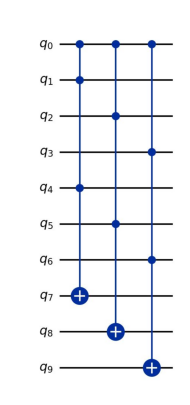

In [12]:
# controlled bitwise conjunction between two registers
# arg 
#    λDim: dimension of λ vector
#    draw: boolean parameter for printing the gate 
# return
#   a gate 

def CBCJ(λDim: int, draw: bool )->Gate:

    qc = QuantumCircuit(3*λDim + 1)

    for i in range(λDim):
        qc.mcx([0, i +1, λDim + i + 1], 2*λDim + i + 1)

    if(draw):draw_circuit(qc)
    qc = qc.to_gate(label="BCJ")
    return qc

# controlled bitwise conjunction between two registers of size λ^i
CBCJ(3, True)

Finally, note that we can build a circuit for CBCJ with  n ancialle qbits that stores a copy of c, so that all CCNOT can be executed in parallel,this means that the overall depth of the circuit is $\mathcal{O}{(log(n))}$ due to the usage of n-fanout operator.

Instruction(name='circuit-189', num_qubits=16, num_clbits=0, params=[])

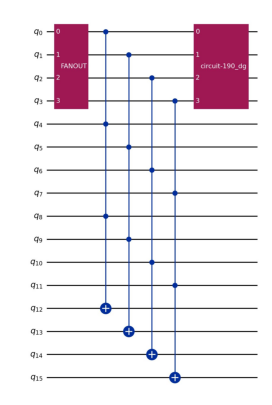

In [13]:
# controlled bitwise conjunction between two registers with ancillae qbits
# arg 
#    λDim: dimension of λ vector
#    draw: boolean parameter for printing the gate 
# return
#   a gate 

def BCJCA(λDim: int, draw: bool )->Gate:
    qc = QuantumCircuit(4*λDim)

    fanout = FANOUT(λDim, False)
    qc = qc.compose(fanout,[i for i in range(λDim)])

    for i in range(λDim):
        qc.mcx([i, i+λDim, i+2*λDim], i+ 3*λDim)

    qc = qc.compose(fanout.inverse(),[i for i in range(λDim)])

    if(draw): draw_circuit(qc)
    
    qc = qc.to_gate(label = "BCJCA")
    return qc 

# example with 4 qbits
BCJCA(4,True)

#### Copy Operator with reversal control

Finally, we present the C operator, it performs the copy of a register |a> of size n into a second register, said |b>, also of size n, initialized to |$0^n$>.Formally,
$$
C|a>|0^n>=|a>|a>
$$
However, we are interested in a controlled version of that operator ,called CCR, which performs a reversal controlled copy, basing on a controlo qbit |c>.Formally,
$$
CRC|c>|a>|0^n>=|c>|a>\otimes_{i=0}^{n-1}|(-c_i) \land a_i>
$$

From what has been said so far, it could seem that CRC is useless, but on the contrary, we need CRC. Indeed, when $\bar{d}$[i]=0, $D^{i-1}$ must remain unchanged.    

Instruction(name='circuit-195', num_qubits=9, num_clbits=0, params=[])

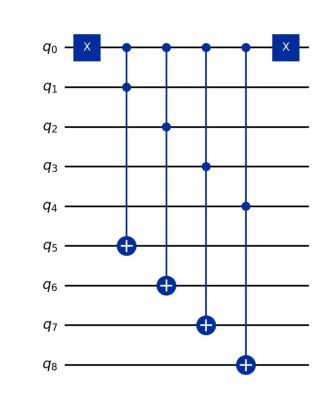

In [14]:
# controlled copy with reversal control
# arg 
#    n: dimension of the register
#    draw: boolean parameter for printing the gate 
# return
#   a gate 
def CRC(n: int, draw: bool)->Gate:

    qc = QuantumCircuit(2*n + 1)

    qc.x(0)

    for i in range(n):
        qc.ccx(0, i + 1, i +n + 1)
    
    qc.x(0)

    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="C")
    return qc 

#Example
#Reversal copy of a register of size n 
CRC(4, True)


Finally,see that we can build a circuit for CRC with  n ancialle qbits that stores a copy of c, so that all CCNOT can be executed in parallel,this means that the overall depth of the circuit is $\mathcal{O}{(log(n))}$ due to the usage of n-fanout operator.

Instruction(name='circuit-198', num_qubits=12, num_clbits=0, params=[])

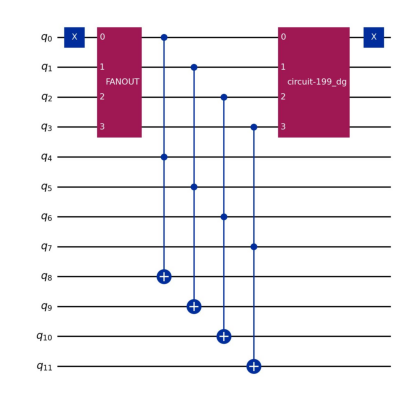

In [15]:
# controlled copy with reversal control with ancillae qbits
# arg 
#    n: dimension of the register
#    draw: boolean parameter for printing the gate 
# return
#   a gate 
def CRCA(n: int, draw: bool)->Gate:

    qc = QuantumCircuit(3*n)

    qc.x(0)
    fanout = FANOUT(n, False)

    qc = qc.compose(fanout, [i for i in range(n)])

    for i in range(n):
        qc.ccx(i, i + n, i +2*n)

    qc = qc.compose(fanout.inverse(), [i for i in range(n)])
    qc.x(0)

    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="C")
    return qc 

#example with n = 4
CRCA(4, True)

### The register disjunction operator

The register disjunction operator V , or simply disjunction operator, computes the
logic or operation between the n qubits of the input register |a > and deposits
the result of such logic operation inside the output qubit, |r >. Formally,
$$
V|a>|0> = |a>|\lor_{i=0}^{n-1}a_i>
$$

Instruction(name='circuit-204', num_qubits=7, num_clbits=0, params=[])

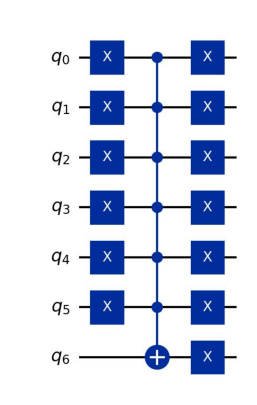

In [16]:
# implementation of disjunction operator
# arg 
#    n: dimension of the register
#    draw: boolean parameter for printing the gate 
# return
#   a gate 

def V(n: int, draw: bool)->Gate:

    qc = QuantumCircuit(n + 1)

    for i in range(n):
        qc.x(i)
    
    qc.mcx([i for i in range(n)], n)

    for i in range(n +1):
        qc.x(i)

    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="V")
    return qc

#example with n = 6
V(6, True)

Even if mcx can be implemented in  $\mathcal{O}{log(n)}$, we decided to use mcx qiskit implementation.

### Pseudocode of the algorithm

FSM(d, x, y, D$^{-1}$ ):
1. λ0 = M(x, y)  
2. if( $\bar{d}$[0] = 1) then D$^{0}$ = (D$^{-1}$ ∧ λ$^{0}$ ) ≫ 2$^{0}$  
3. for i = 1 to log(d) do  
4.  λ$^{i}$ = EXT$_{i}$(λ$_{i-1}$)
5.  if ($\bar{d}$[i] = 1) then D$^i$ = (D$^{i-1}$ ∧ λ$^{i}$ ) ≫ 2$^{i}$  
6.  else D$^{i}$ = D$^{i-1}$
7.  end for 
8. r=V$_{j=d}^{n}$D$^{log(d)}$[j$\cdot$ mod(n)]  
9. return r

We decided to report this pseudocode since it give us a significant guideline in the construction of the circuit that implement the algorithm. Basically, the circuit is a convoluted composition of the gates we introduced earlier. 

## The circuit

In this section, we give an implementation of the quantum circuit that simulate the algorithm. 

### Circuit initialization

 Recall that we need to  instantiate:
 - a register of size |x| that contains the string x
 - a register of size |y| that contains the string y
 - a register of size  $\lfloor log(d) \rfloor$ that contains d in its binary representation
 - $\lfloor log(d) \rfloor$ registers of size n, n - 1, n - 3... that contains $\lambda$ vectors
 - $\lfloor log(d) \rfloor$ registers of size n that contains D vectors 

In [17]:
# function that initialize the circuit 
# arg 
#    x: first string in input 
#    y: second string in input 
#    d: length of the substring we are looking for
#    draw: boolean parameter for printing the gate 
# return
#   a quantum circuit 


def initializeCircuit(x: str, y: str, d: int, ancillae: bool, testMode: bool)->QuantumCircuit:
    dBinaryVersion = bin(d)[2:]

    numberOfVectors = floor(log2(d)) + 1
    n = len(x)
    m = len(dBinaryVersion)
    numberOfQbitsUsed = 2*n + m + (numberOfVectors+1)*n + 1

    #Classical Register that will contains final D vector
    if(testMode):
        r = ClassicalRegister(n, "result")
    else:
        r = ClassicalRegister(1, "result")

    QuantumRegisters = []

    QuantumRegisters.append(QuantumRegister(n, name="x"))
    QuantumRegisters.append(QuantumRegister(n, "y"))
    QuantumRegisters.append(QuantumRegister(m, "d"))
    
    if(ancillae): 
        QuantumRegisters.append(QuantumRegister(n-1, "anc"))
        numberOfQbitsUsed+=n-1

    for i in range(numberOfVectors):
        QuantumRegisters.append( QuantumRegister(n - 2**i + 1, name="λ" + str(i)))
        numberOfQbitsUsed+= n - 2**i + 1

    
    for i in range(-1, numberOfVectors):
        QuantumRegisters.append(QuantumRegister(n, name="D" + str(i)))
    
    QuantumRegisters.append(QuantumRegister(1, "v"))

    qc = QuantumCircuit(*QuantumRegisters, r)

    print("numQbits used:" + str(numberOfQbitsUsed))

    return qc 

### Input initialization

Recall that input parameter are:
- a string x
- a string y
- an integer d

In [18]:
#print results of the measurement
# arg:
#   x: first input string 
#   y: second input string
#   d: passed as a binary string rather than an integer
# return:
#  a Gate
def initInput(x: str, y: str, d:str)->Gate:
    n = len(x)
    dLen = len(d)
    qc = QuantumCircuit(2*n + dLen)

    #initializing input strings
    for i in range(n):
        if(x[i] == "1"): qc.x(i)
        if(y[i] == "1"): qc.x(n+i)

    #initializing binary version of d
    for i in range(dLen):
        if(d[i] == "1"): qc.x(2*n + i)

    qc = qc.to_gate(label="init")

    return qc 

### Vector D initialization 

Unlike other registers, the initialization of vector $D^{-1}$ is quite sensitive, because it depends on the problem we want to solve:
- If we want to solve FPM problem, we should initialize D to ($01^{n-1}$)
- If we want to solve FFM problem, we should initialize D to ($0^{j-1}$$1$$0^{n-j}$)
- If we want to solve SFSC problem, we should initialize D to $1^n$

Instruction(name='circuit-207', num_qubits=8, num_clbits=0, params=[])

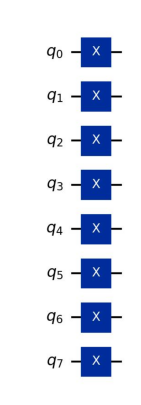

In [19]:
# function that initialize D for solving SFSC problem 
# arg 
#    n: the dimension of the register D 
#    draw: boolean parameter for printing the gate
# return
#   a quantum circuit 

def SFSCinit(n, draw):

    qc = QuantumCircuit(n)

    for i in range(n):
        qc.x(i)

    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="ID")
    return qc

#Initialization of vector D 
SFSCinit(8, True)

Instruction(name='circuit-210', num_qubits=1, num_clbits=0, params=[])

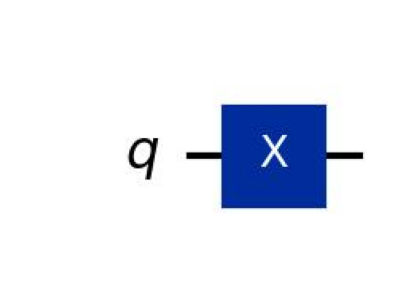

In [20]:
# function that initialize D for solving FPM and FFM problem 
# arg
#    draw: boolean parameter for printing the gate
# return
#    a quantum circuit 

def FPMinit(draw):
    qc = QuantumCircuit(1)

    qc.x(0)

    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="ID")
    return qc

FPMinit(True)

### Circuit of FSM algorithm

In [21]:
# function that create a circuit to solve the fixed substring comparison problem  
# arg 
#    x: first string in input 
#    y: second string in input 
#    d: length of the substring we are looking for
#    ancillae: parameter that specifies if we want to use ancillae qbits to speed up the computation
#    draw: boolean parameter for printing the gate
#    mode: parameter that specifies the problem we would like to solve : FPM FFM SFSC
#    positionToCheck: parameter that specifies the start position for FFM
#    testMode: parameter thtat specifies if we want to print the entire D^log(d) vector or only the logic or result
# return
#    dictionary containing results

def fsmAlgorithm(x: str, y: str, d: int,  ancillae: bool, draw : bool, mode = 'SFSC', positionToCheck = None, testMode=False)->dict:

    numIter = floor(log2(d)) + 1
    dBin = bin(d)[2:]
    dLen = len(dBin)
    n = len(x)
    
    qc = initializeCircuit(x, y, d, ancillae, testMode)
    
    init = initInput(x, y, dBin)
    qc = qc.compose(init, [i for i in range(2*n + dLen)])

    qc.barrier()

    #this gate reverse bits of d 
    rev = REV(dLen, False)
    qc = qc.compose(rev, [i for i in range(2*n, 2*n +  dLen)])
   
    qc.barrier()

    #construction of  λ^0
    m = M(n,  False)
    if(ancillae): qc = qc.compose(m, [i for i in range(0, 2*n)] + [i + 3*n - 1 + dLen for i in range(n)])
    else: qc = qc.compose(m, [i for i in range(0, 2*n)] + [i + 2*n + dLen for i in range(n)])

    qc. barrier()

    endInput = 2*n + dLen
    if(ancillae): endInput+=n-1
    startCurrentLamdaVector = endInput

    for i in range(numIter - 1):
        ext = EXT(n, i,  False)
        qc = qc.compose(ext,[j +  startCurrentLamdaVector for j in range(n)] +
                         [j +  startCurrentLamdaVector + n for j in range(n - 2**i)])
        startCurrentLamdaVector+= n 
        n = n - 2**i
        qc.barrier()

    startDvectors =  startCurrentLamdaVector + n

    n = len(x)
    match(mode):
        case 'SFSC':
            initializeD= SFSCinit(n, False)
            qc = qc.compose(initializeD, [startDvectors  + j for j in range(n)])
        case 'FPM':
            initializeD = FPMinit(False)
            qc = qc.compose(initializeD, [startDvectors])
        case 'FFM':
            initializeD = FPMinit(False)
            qc = qc.compose(initializeD, [startDvectors + positionToCheck])
        

    currentLambdaVectorDimension = n
    startCurrentLambdaVector = endInput
    ancialleQbitsStartPosition = endInput - n + 1 

    for i in range(1, dLen +1):
        #an iteration of the cicle consist in a bitwise-conjuction operator,
        # controlled-rotation operator and controlled-copy operator
        controlQbitPosition = endInput  - dLen + i - 1
        controlQbitsPositionAncillae = endInput  -  dLen - n + i 
        
        if(not ancillae):
            bcj = CBCJ( currentLambdaVectorDimension,False)
            qc = qc.compose(bcj, [controlQbitPosition] + 
                            [j +  startCurrentLambdaVector for j in range( currentLambdaVectorDimension)]+
                            [j + startDvectors  + (i-1)*n for j in range( currentLambdaVectorDimension)] + 
                            [j + startDvectors + i*n for j in range(currentLambdaVectorDimension)])
        else:
            bcj = BCJCA( currentLambdaVectorDimension, False)
            qc = qc.compose(bcj, [controlQbitsPositionAncillae] + 
                            [j + ancialleQbitsStartPosition for j in range( currentLambdaVectorDimension - 1)] + 
                            [j + startCurrentLambdaVector for j in range(currentLambdaVectorDimension)] + 
                            [j +  startDvectors  + (i-1)*n for j in range( currentLambdaVectorDimension)] +
                            [j + startDvectors +i*n for j in range( currentLambdaVectorDimension)])

        
        if(not ancillae):
            rot = CROT(n, 2**(i-1), False)
            qc = qc.compose(rot, [controlQbitPosition] + [startDvectors + i*n + j 
                                                            for j in range(n)])
        else:
            rot = CROTA(n, 2**(i-1), False) 
            qc = qc.compose(rot, [controlQbitsPositionAncillae] + 
                            [j +  ancialleQbitsStartPosition for j in range(n - 1)] + 
                            [startDvectors + i*n + j for j in range(n)])
        
        if(not ancillae):
            c = CRC(n, False)
            qc = qc.compose(c, [controlQbitPosition] +  
                            [j + startDvectors + (i-1)*n for j in range(n)] + 
                            [j + startDvectors + i*n for j in range(n)])
        else:
            c = CRCA(n, False)
            qc = qc.compose(c, [controlQbitsPositionAncillae] + 
                               [j +  ancialleQbitsStartPosition for j in range(n-1)] +
                               [j + startDvectors + (i-1)*n for j in range(n)] +
                               [j + startDvectors + i*n for j in range(n)])
            
        startCurrentLambdaVector += currentLambdaVectorDimension
        currentLambdaVectorDimension =  currentLambdaVectorDimension - 2**(i-1)
        
        qc.barrier()
    
    #this gate store the result in a classical register 
    startLastDvector = startDvectors + dLen*n

    if(testMode): 
        qc.measure([ startLastDvector + j for j in range(n)], [j for j in range(n)])
    else:
        v = V(n, False)
        qc = qc = qc.compose(v, [j +  startLastDvector for j in range(n+1)])
        qc.measure([startLastDvector +n], 0)

    if(draw): 
        draw_circuit(qc)

    res = run(qc, 20)
    return res 



## Results

Here, there are different execution of the circuit shown above

numQbits used:58
result:
1


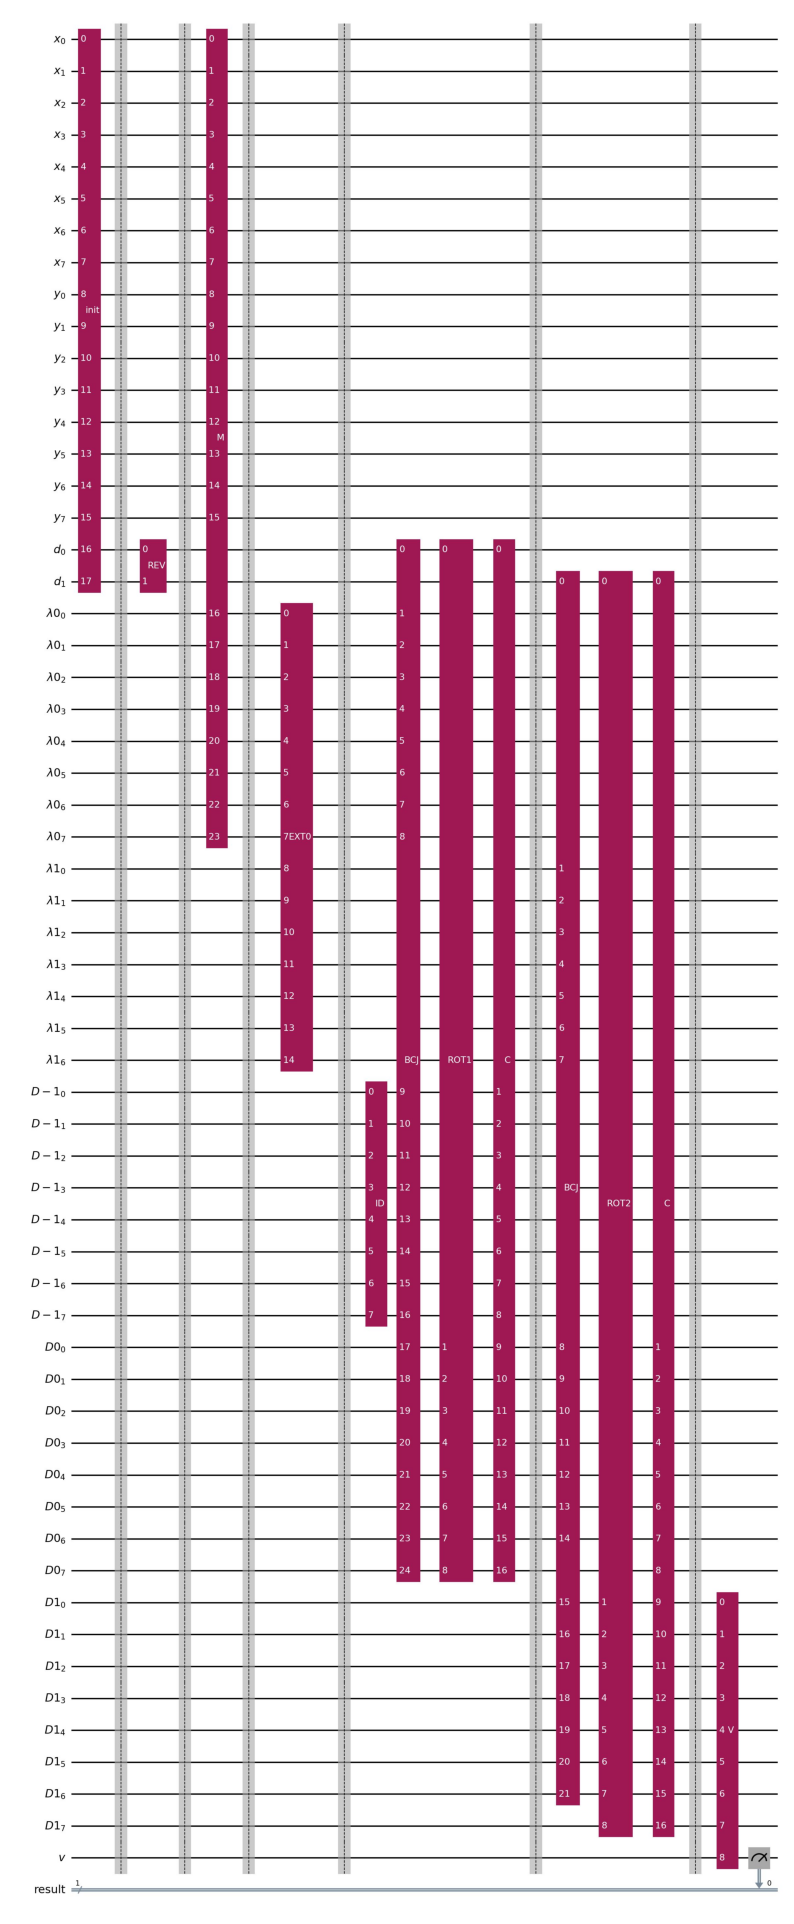

In [22]:
matplotlib.rcParams['figure.figsize'] = [10, 60]
res= fsmAlgorithm(x="10101110", y="10110110", d=3, ancillae=False, draw= True, mode= 'SFSC', testMode = False)
print("result:")
counts(res)

numQbits used:33
result:
1


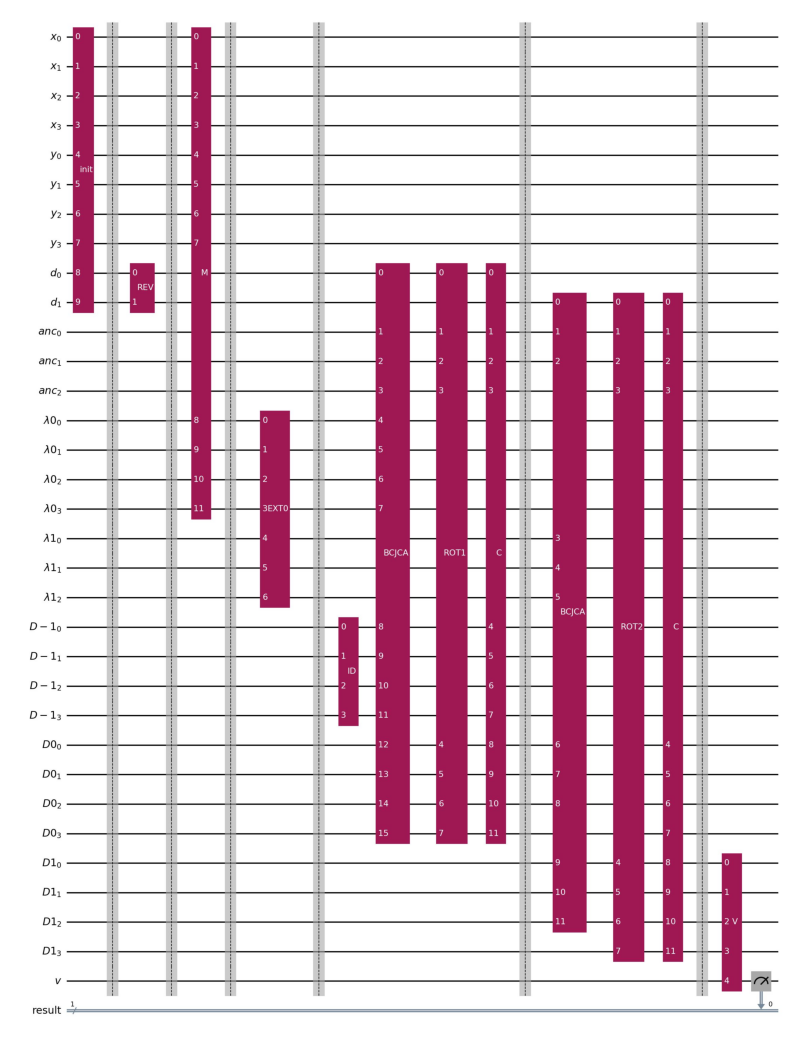

In [23]:
matplotlib.rcParams['figure.figsize'] = [10, 60]
res= fsmAlgorithm(x="1010", y="1011", d=2, ancillae=True, draw= True, mode= 'SFSC', testMode = False)
print("result:")
counts(res)

numQbits used:58
result:
1


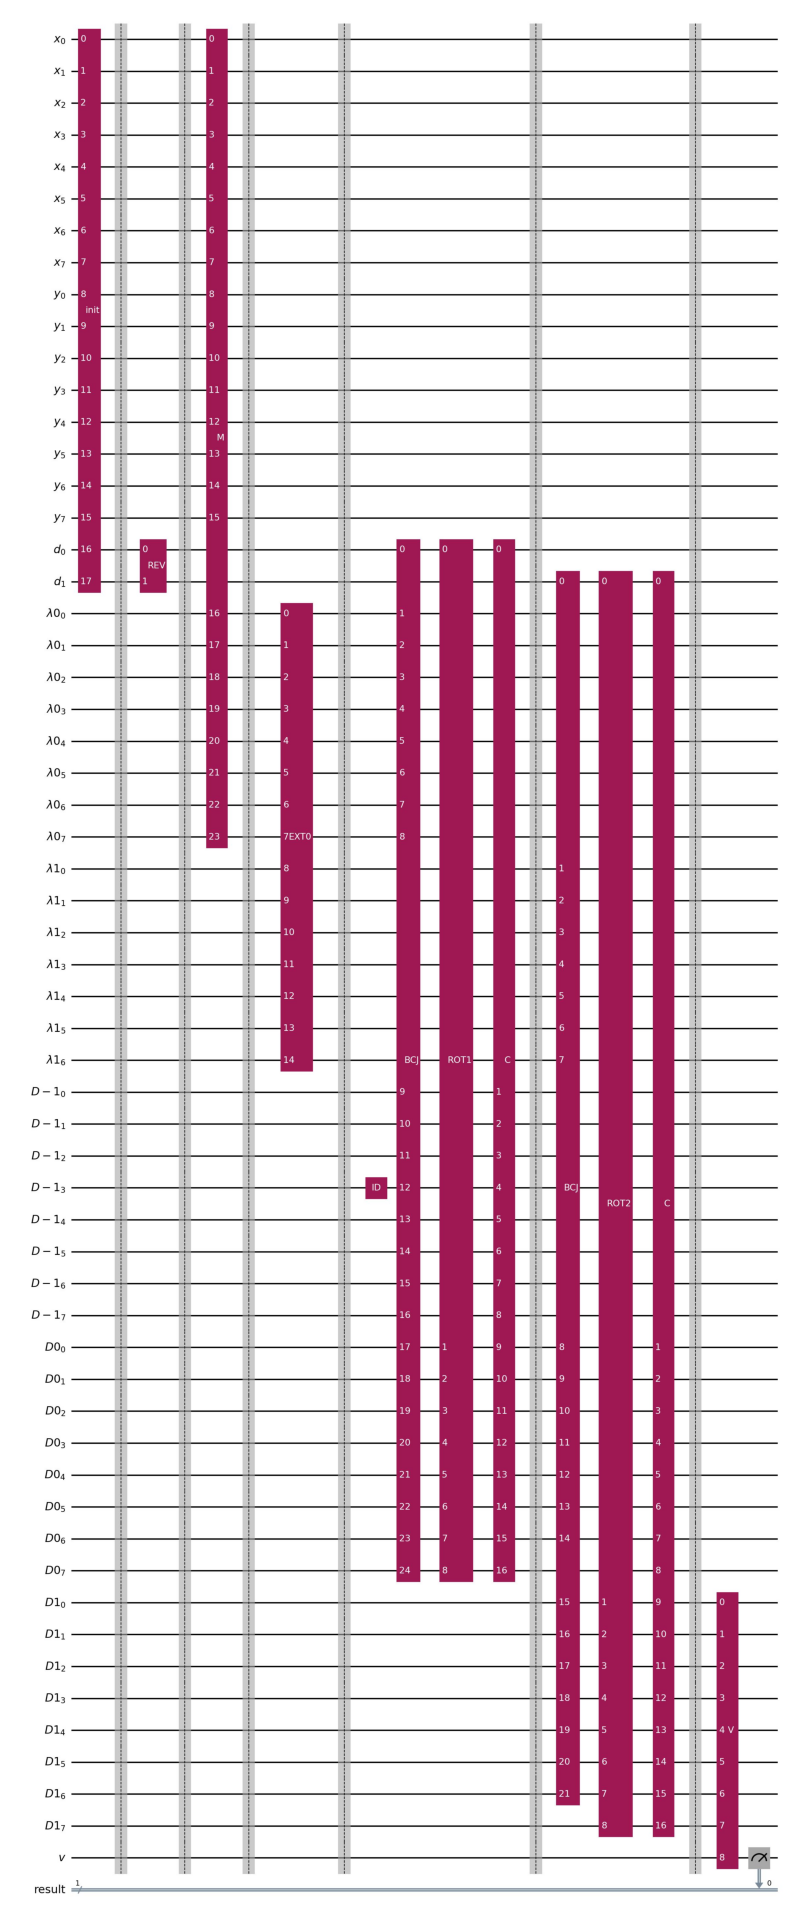

In [24]:
matplotlib.rcParams['figure.figsize'] = [10, 60]
res= fsmAlgorithm(x="10111011", y="10111010", d=3, ancillae=False, draw= True, mode= 'FFM', positionToCheck = 3, testMode = False)
print("result:")
counts(res)

numQbits used:33
result:
0


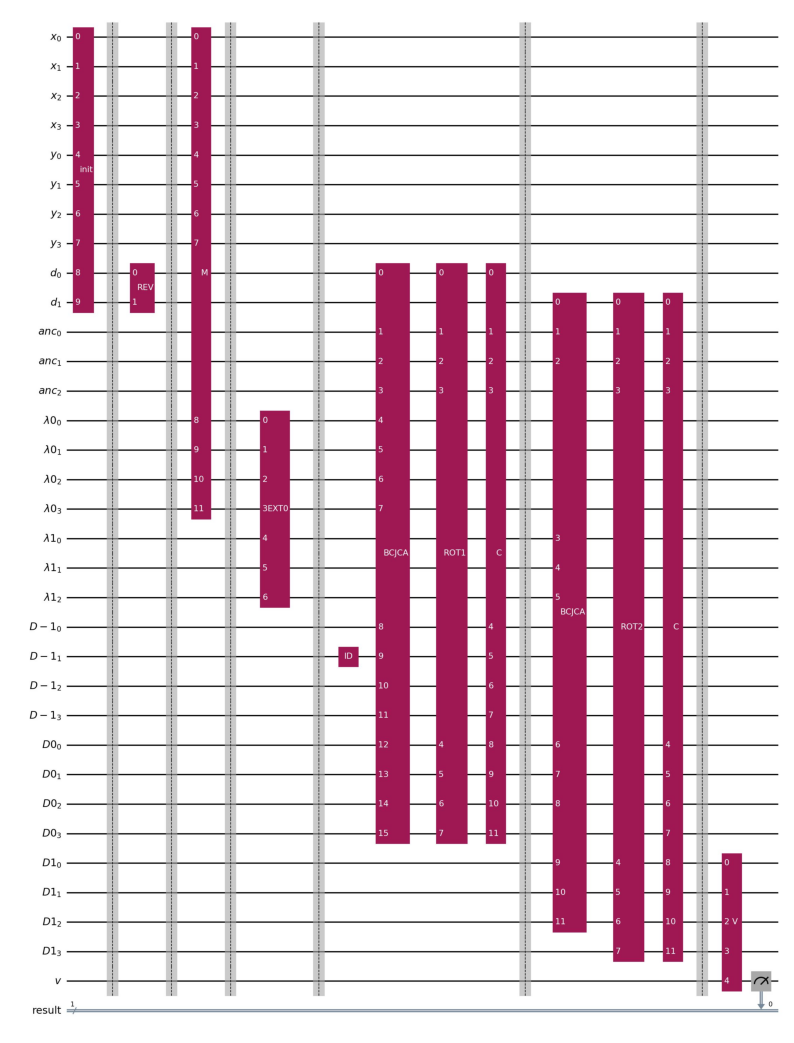

In [25]:
matplotlib.rcParams['figure.figsize'] = [10, 60]
res= fsmAlgorithm(x="1101", y="1011", d=2, ancillae=True, draw= True, mode= 'FFM', positionToCheck = 1, testMode = False)
print("result:")
counts(res)

numQbits used:58
result:
1


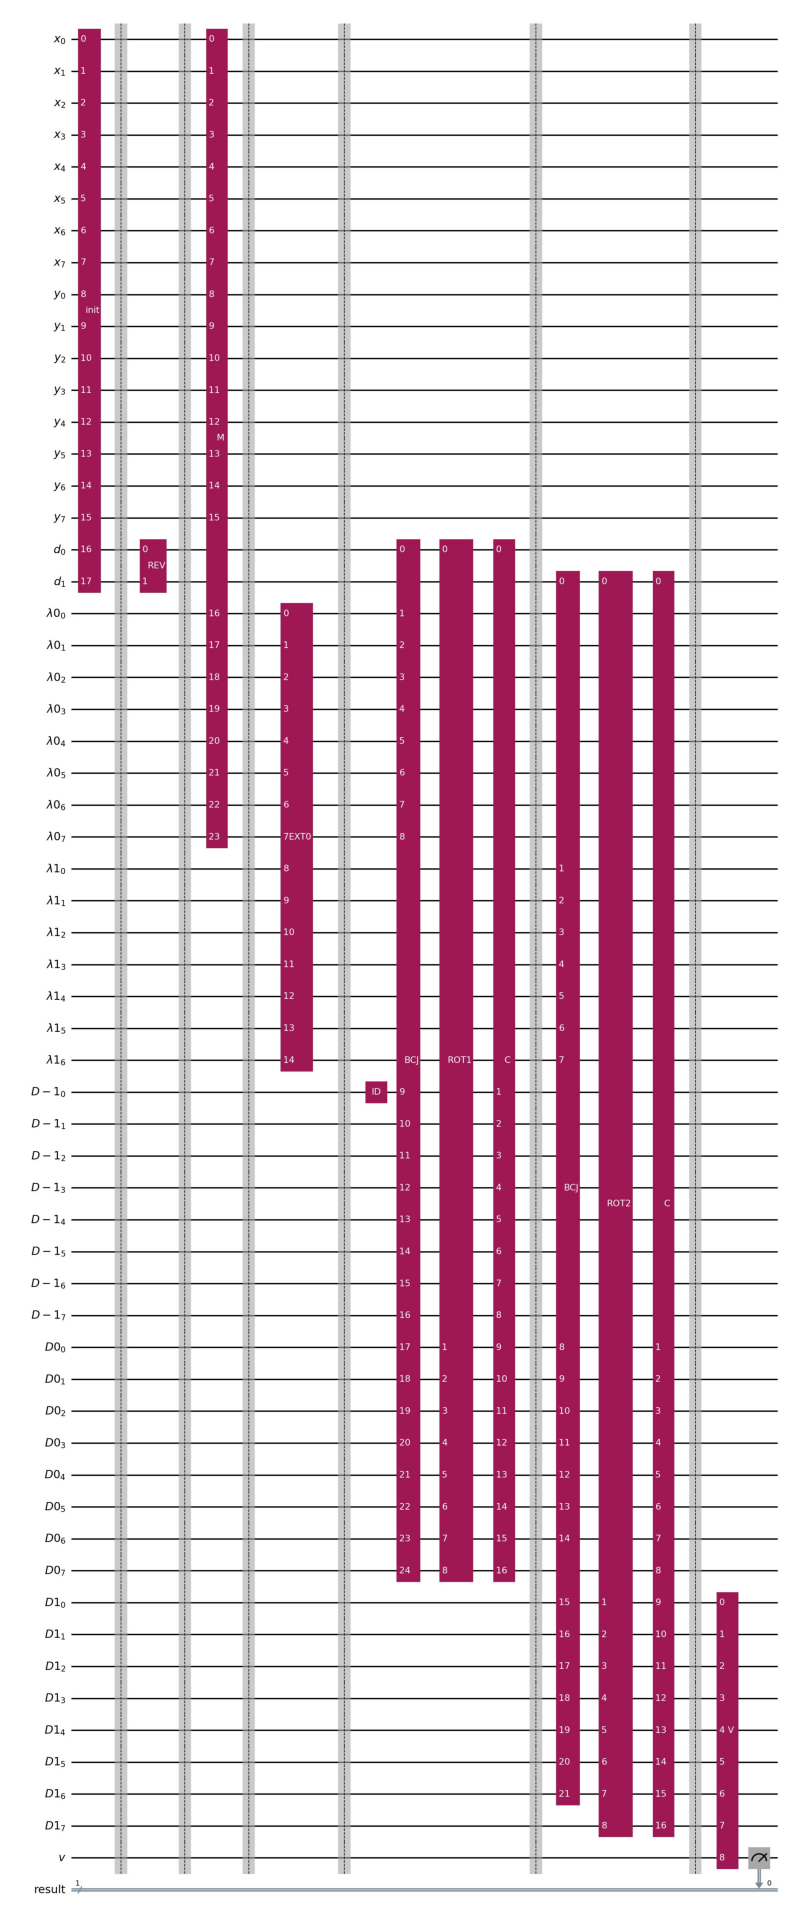

In [26]:
matplotlib.rcParams['figure.figsize'] = [10, 60]
res= fsmAlgorithm(x="10111011", y="10111010", d=3, ancillae=False, draw= True, mode= 'FPM', testMode = False)
print("result:")
counts(res)

numQbits used:33
result:
1


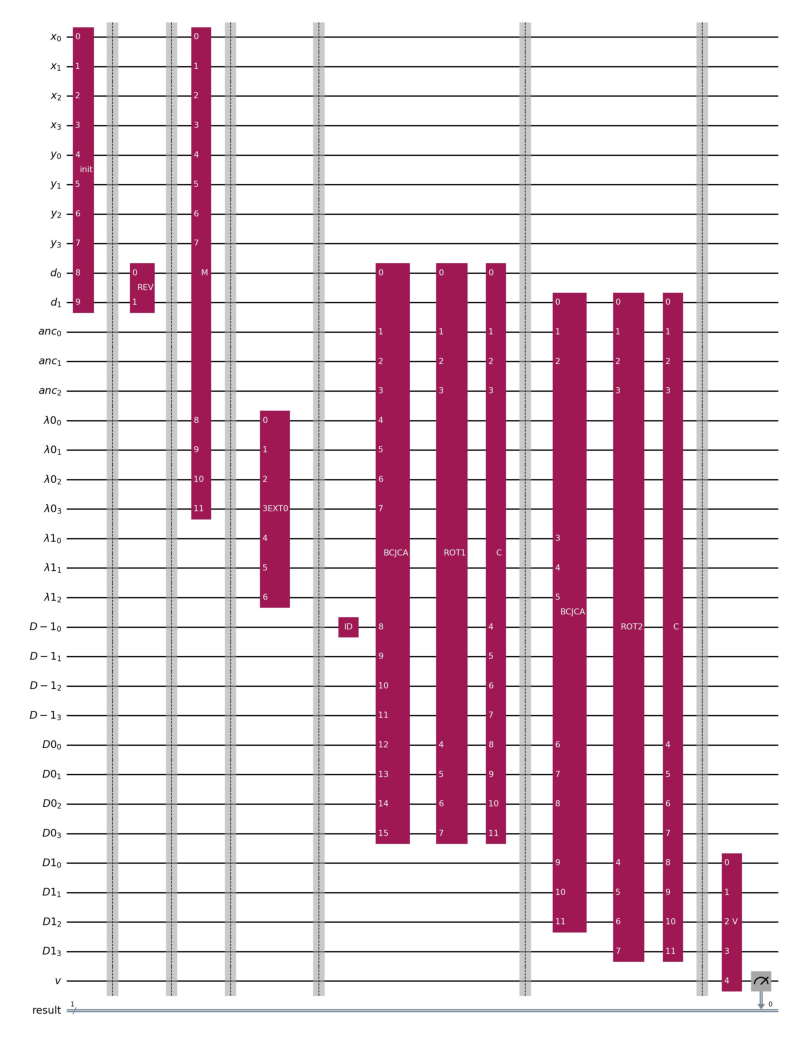

In [27]:
matplotlib.rcParams['figure.figsize'] = [10, 60]
res= fsmAlgorithm(x="0011", y="0010", d=3, ancillae=True, draw= True, mode= 'FPM', positionToCheck = 3, testMode = False)
print("result:")
counts(res)

### Let's try the code

Please remember the restriction:
- x and y must have the same size
- x and y must have a length that is a power of two
- qbits used must be less than 63

In [34]:
x = str(input('Enter the value of x: '))
y = str(input('Enter the value of y: '))
d= int(input('Enter the value of d: '))
ancillae = bool(int(input('Do you want to use ancillae qbits?')))
mode = str(input('choose the problem you want to solve: '))

n = len(x)

positionToCheck = None
if(mode == 'FFM'):
   positionToCheck = int(input('choose the position: '))

# mode must be FFM FPM or SFSC
if(mode != 'FFM' and mode != 'FPM' and mode != 'SFSC'):
    raise Exception("error on input parameter:\n mode =FFM|FPM|SFSC")

#Obviously x and y must have the same length and d must be different from 0
if(n != len(y) or d == 0):
    raise Exception("error on input parameter:\n x and y must have the same length")
    
# We suppose for simplicity that the length of x and y is a power of two
if(n & n -1):
    raise Exception("error on input parameter:\n length of the string must be a power of two")

# Obviously, if mode is Fixed Factor Matching the position where to check the existence of
# the common factor must be initialized
if(mode == 'FFM' and (positionToCheck == None or positionToCheck not in range(n-d))):
    raise Exception("error on in input :\n when mode=FFM offset must be initialized")

#matplotlib.rcParams['figure.figsize'] = [20, 20]
result = fsmAlgorithm(x, y, d, ancillae, False, mode, positionToCheck, True) 
print("result:")
counts(result)

Enter the value of x:  11101010
Enter the value of y:  00101110
Enter the value of d:  3
Do you want to use ancillae qbits? 0
choose the problem you want to solve:  SFSC


numQbits used:58
result:
00000100


## Quantum vs classic implementation

In this section, we will discuss the performance of our quantum algorithm, making a comparision with classic solutions for this family of problems.  
Firstly, let's indagate the overall complexity of the circuit:  
- initialization of the input and REV operator take time  $\mathcal{O}{(1)}$
- M and EXT operator takes time  $\mathcal{O}{(1)}$ but we need to calculate log(d) $\lambda$ vectors, so the whole process takes time  $\mathcal{O}{(log(n))}$
- if we use n ancillae qbits BCJ, ROT and CRC can be computed in  $\mathcal{O}{(log(n))}$,  $\mathcal{O}{(log^2(n))}$,  $\mathcal{O}{(log(n))}$, so the entire computation can be in done in  $\mathcal{O}{(log^2(n))}$
- if we use n/2 ancillae qbits, the computation of operator V can be done in  $\mathcal{O}{(log(n))}$

Therefore, our final circuit will have depth  $\mathcal{O}{(log^3(n))}$.Moreover, note that strings are represented in binary format, so some may argue that the usage of characters could led to substantial increase of the  asymptotic performance.However, assuming that characters can be represented with at most log(n) bits, it is easy to show that the quantum complexity of the operators would undergo an increase in their complexity at most equal to a factor of log(n). Thus, the quantum complexity of the overall circuit remains polylogarithmic.  
Best classic algorithms for solving this family of problems led to  $\mathcal{O}{(n)}$ time complexity, achieved by Knut-Morris-Pratt algorithm and two-way algorithm, so we can state the asymptotic perfomance superiority of our quantum implementation.However, in practise classic algorithm is the best choice, because our quantum implementation has a huge limitation due to the amount of qbits used. Indeed, the powerful quantum computer has at most a hundred of qbits, while a large text would need billions of qbits to compute the result. 

## Conclusion

In conclusion, this algorithm cannot be used in practise.Maybe, in the future we will uncover a method to store many classical bits in a single qbits or maybe we should just wait for more powerful quantum computers.

## References

- [Fixed substring matching algorithm](https://arxiv.org/abs/2308.11758)
- [Quantum cyclic rotation gate](https://ceur-ws.org/Vol-3587/4071.pdf)